In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2153 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 1 0 1 0 0 0 0 1 2 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0]


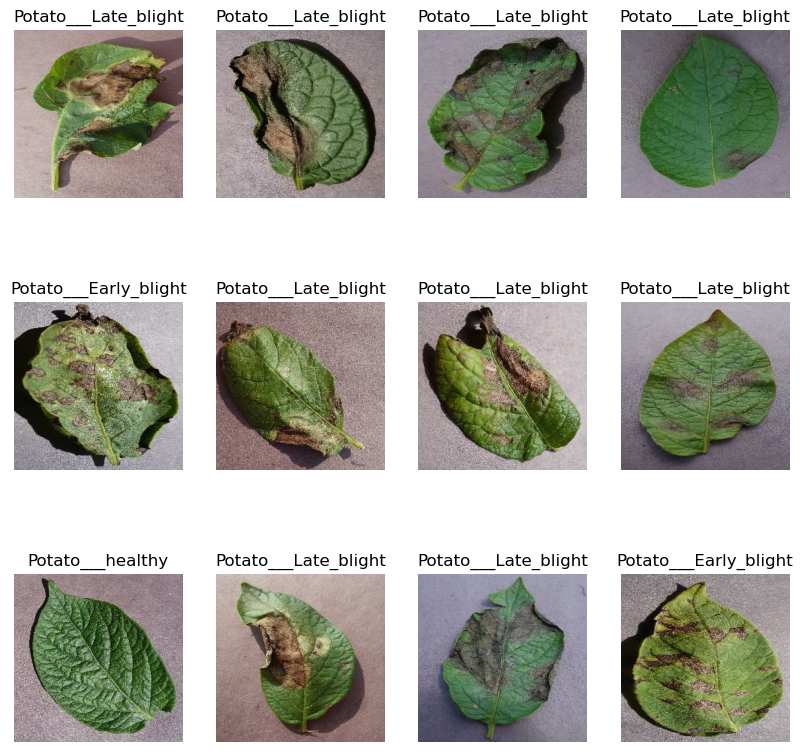

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
#*80% ==>training,
#0% ==>10% validation, 10% test

In [9]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds=dataset.take(54)
len(train_ds)

54

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale =tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [22]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_andvertical"),
    layers.RandomRotation(0.2),
])

In [23]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,

    #1st Layer
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    # 2nd Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 3rd Convolutional Block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 4th Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 50176)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,599,939 (13.73 MB)

 Trainable params: 3,599,939 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
   train_ds,
   epochs=EPOCHS,
   batch_size=BATCH_SIZE,
   verbose=1,
   validation_data=val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.5999 - loss: 0.9280 - val_accuracy: 0.8177 - val_loss: 0.5380
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.8158 - loss: 0.4965 - val_accuracy: 0.8802 - val_loss: 0.2994
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 289s 5s/step - accuracy: 0.8608 - loss: 0.3396 - val_accuracy: 0.9115 - val_loss: 0.3245
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 276s 5s/step - accuracy: 0.8852 - loss: 0.2932 - val_accuracy: 0.9271 - val_loss: 0.2009
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.9248 - loss: 0.2273 - val_accuracy: 0.8281 - val_loss: 0.3625
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.9492 - loss: 0.1312 - val_accuracy: 0.8333 - val_loss: 0.3936
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.9601 - loss: 0.1181 - val_accuracy: 0.9635 - val_loss: 0.1291
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.9704 - loss: 0.0952 - val_accuracy: 0.9531 - v

In [27]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9747 - loss: 0.0917


In [28]:
scores

[0.10170543193817139, 0.96875]

In [29]:
history 

In [30]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
history.history['accuracy']

[0.6892361044883728,
 0.8408564925193787,
 0.8680555820465088,
 0.8871527910232544,
 0.9276620149612427,
 0.9403935074806213,
 0.953125,
 0.9548611044883728,
 0.9537037014961243,
 0.9745370149612427]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

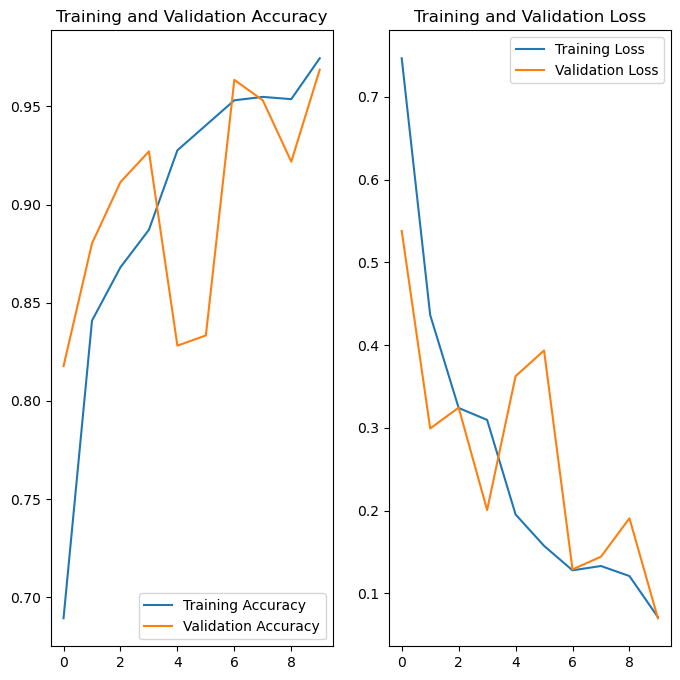

In [34]:
plt.figure(figsize =(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS),acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Potato___Early_blight


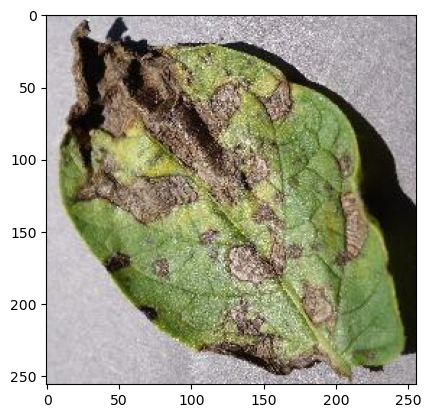

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


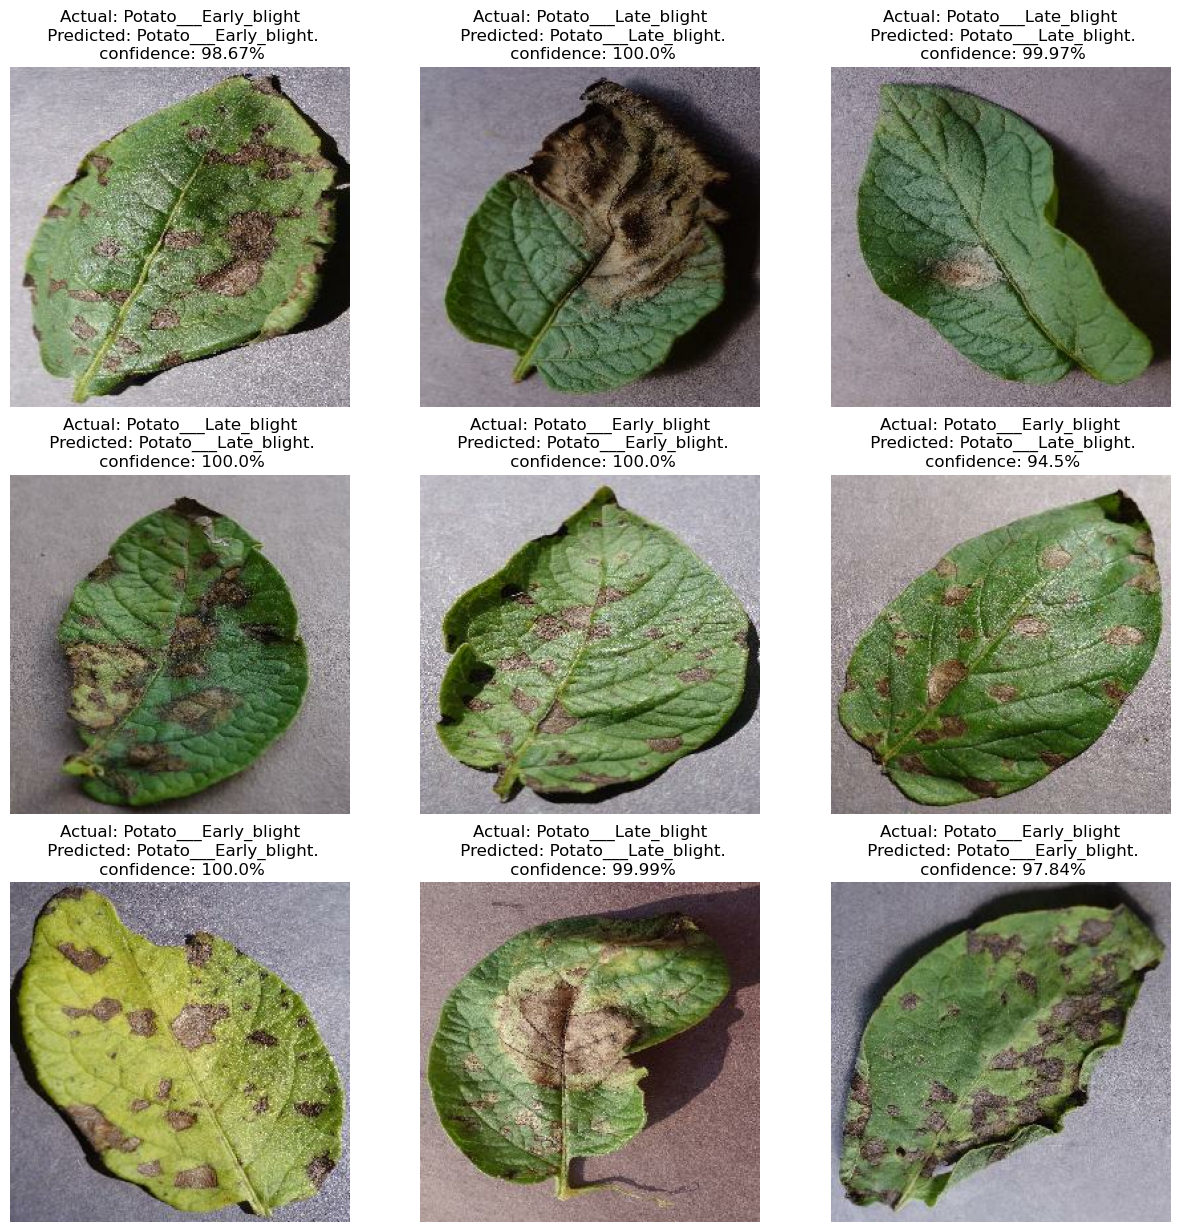

In [37]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}.\n confidence: {confidence}%")


        plt.axis("off")


In [42]:
import os
os.listdir("model")

[]

In [43]:
# Define the variable bellpepper_dep
bellpepper_dep = "v1.0"  # You can set this to the appropriate version string

# Now you can use it to save the model
model_version = bellpepper_dep
model.save(f"model/{model_version}.keras") 

In [48]:
# Load the existing Keras model (.keras, .h5, or similar)
model = tf.keras.models.load_model('model/v1.0.keras')

# Save in the TensorFlow SavedModel format
model.export('C:/Users/user/Documents/GitHub/BLOOM-ML/Potato-Disease Model/model')


INFO:tensorflow:Assets written to: C:/Users/user/Documents/GitHub/BLOOM-ML/Potato-Disease Model/model\assets


INFO:tensorflow:Assets written to: C:/Users/user/Documents/GitHub/BLOOM-ML/Potato-Disease Model/model\assets


Saved artifact at 'C:/Users/user/Documents/GitHub/BLOOM-ML/Potato-Disease Model/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2333086670800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086671760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086672336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086673680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086673104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086674448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086673872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086675216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086671376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086676176: TensorSpec(shape=(), dtype=tf.resource

In [50]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('bellpepper_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpu9jysqg7\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpu9jysqg7\assets


Saved artifact at 'C:\Users\user\AppData\Local\Temp\tmpu9jysqg7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(32, 3), dtype=tf.float32, name=None)
Captures:
  2333086672336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086673680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086673104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086674448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086673872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086675216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086671376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086676176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086672912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2333086677136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23330866769

In [54]:
model.save('model_name.h5')

In [56]:
# Load the model
model = tf.keras.models.load_model('model_name.h5')

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
